<a href="https://colab.research.google.com/github/twishajain/YOLO/blob/master/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLO

**Image**



In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:

from google.colab import files
uploaded = files.upload()


Saving living_room.jpg to living_room (1).jpg


[INFO] loading YOLO from disk...
[INFO] YOLO took 1.288635 seconds


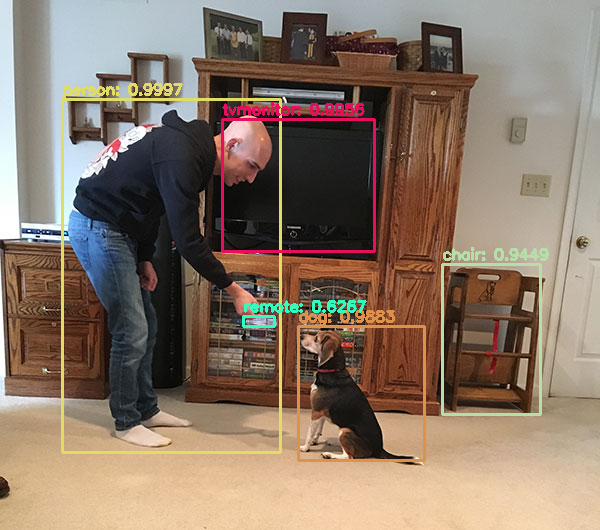

In [24]:
# import the necessary packages
import numpy as np
import argparse
import time
import cv2
import os

########download coco.name, yolov3.weights, yolov3.cfg from file named coco and replace with your new paths
labelsPath = os.path.sep.join([r"/content/drive/My Drive/Colab Notebooks", "coco.names"])

LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([r"/content/drive/My Drive/Colab Notebooks", "yolov3.weights"])
configPath = os.path.sep.join([r"/content/drive/My Drive/Colab Notebooks", "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)


# load our input image and grab its spatial dimensions
########replace living_room.jpeg with your uploaded file name
image = cv2.imread("/content/living_room.jpg")
(H, W) = image.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
 
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
 
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
 
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)
      
      # apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5,0.3)

# ensure at least one detection exists
from google.colab.patches import cv2_imshow

if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
 
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)
 
# show the output image
cv2_imshow( image)
